# Time series forecasting and BitPredict

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub
import shutil


## Get Data


In [2]:
# !curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  174k  100  174k    0     0   167k      0  0:00:01  0:00:01 --:--:--  167k


In [2]:
dataset = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
dataset.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
bitcoin_prices = pd.DataFrame(dataset["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


<Axes: title={'center': 'Bitcoin Price History'}, xlabel='Date', ylabel='Price'>

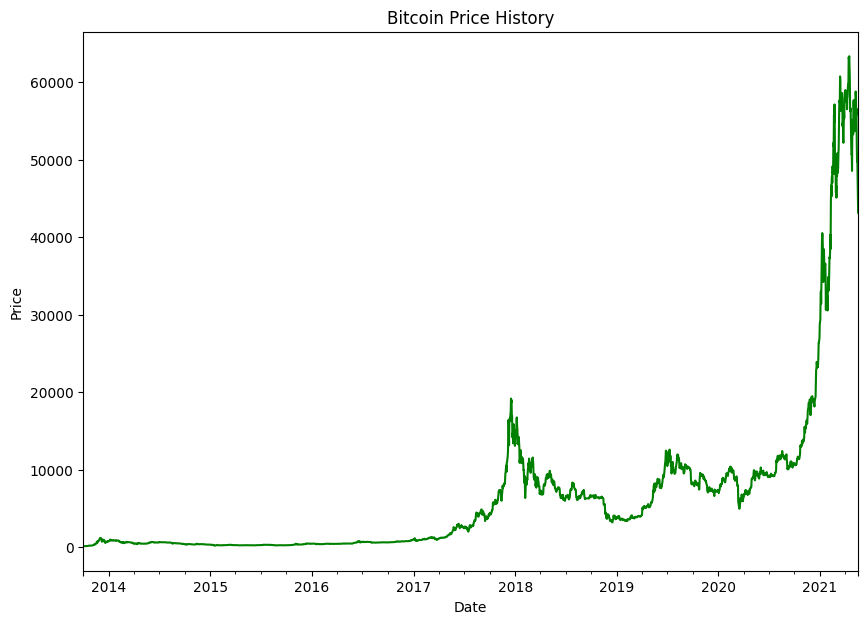

In [9]:
bitcoin_prices.plot(
    figsize=(10, 7),
    title="Bitcoin Price History",
    xlabel="Date",
    ylabel="Price",
    legend=False,
    color="green",    
)

In [56]:
split_size = int(0.8 * len(bitcoin_prices))

X_train, y_train = bitcoin_prices.index[:split_size].to_numpy(), bitcoin_prices.Price[:split_size].to_numpy()
X_test, y_test = bitcoin_prices.index[split_size:].to_numpy(), bitcoin_prices.Price[split_size:].to_numpy()

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

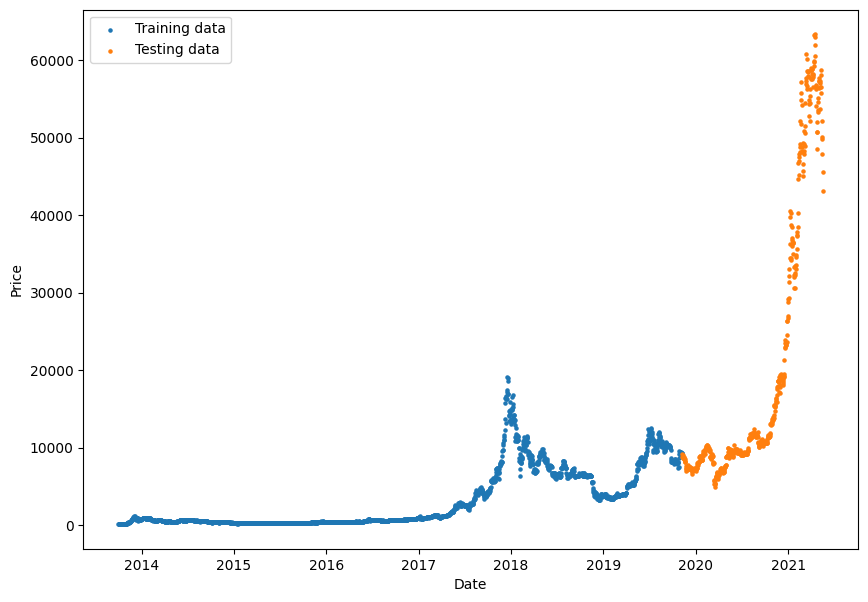

In [57]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Training data")
plt.scatter(X_test, y_test, s=5, label="Testing data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show();

In [58]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

In [73]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Returns the mean absolute scaled error between y_true and y_pred.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
    """
    Performs various evaluation comparison on y_true labels vs. y_pred labels.

    Parameters
    ----------
    y_true : array of true labels
    y_pred : array of predicted labels

    Returns a dictionary of different evaluation metrics.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    # Account for zero division
    if mae.numpy() == 0:
        mase = 0
    else:
        mase = mase.numpy()
    # Create dictionary of metrics
    metrics = {"mae": mae.numpy(),
               "mse": mse.numpy(),
               "rmse": rmse.numpy(),
               "mape": mape.numpy(),
               "mase": mase}
    return metrics

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [99]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    # print(f"Window indexes:\n {window_indexes}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(f"Target time series:\n {x}")
    # print(f"Target time series Shape: {x.shape}")
    
    # print(f"Windowed time series:\n {windowed_array}")
    # print(f"Windowed time series Shape: {windowed_array.shape}")

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [103]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    Returns two tuples of (windows, labels) train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

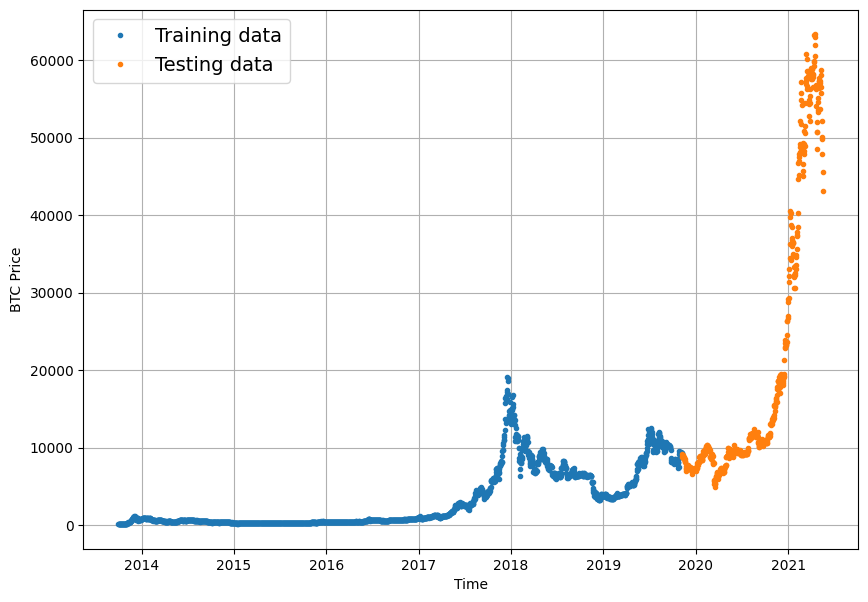

In [59]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Training data")
plot_time_series(timesteps=X_test, values=y_test, label="Testing data")


## Modeling

### Model 0: Naive forecast (baseline)

In [60]:
naive_forecast = y_test[:-1]

naive_forecast[:10], y_test[:10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

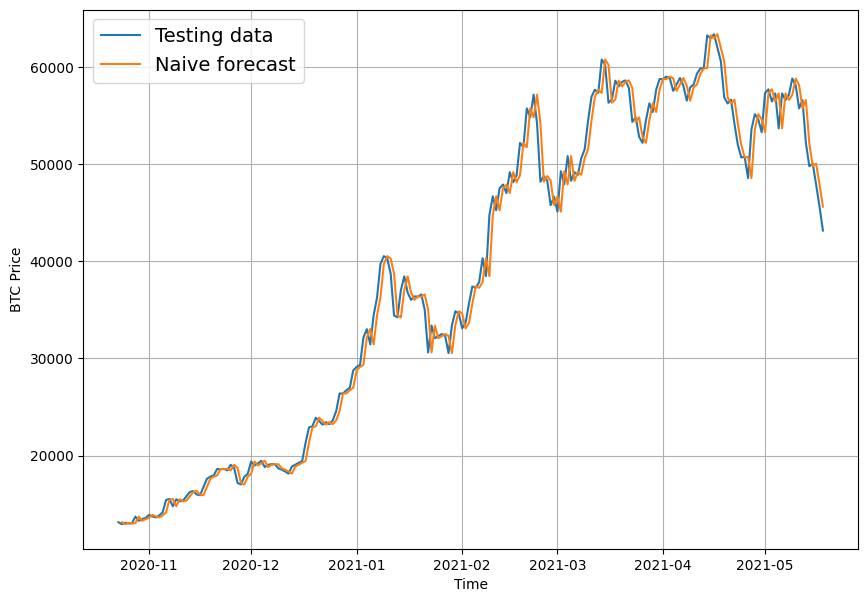

In [61]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Testing data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")


In [68]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182626>

In [72]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.1,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Windowing for 1 week

In [81]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()}\nLabel: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6]
Label: 7


In [97]:
full_windows, full_labels = make_windows(bitcoin_prices["Price"].to_numpy())

In [98]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [105]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Making Callbacks

In [ ]:
def get_callbacks(experiment_name, use_early_stopping = False, patience=3):
    if use_early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience,
            restore_best_weights=True,
        )
    callbacks = [
        create_tensorboard_callback(
            dir_name="bit_predict/tensorboard",
            experiment_name=experiment_name,
        ),
        create_checkpoint_callback(
            dir_name="bit_predict/checkpoint",
            experiment_name=experiment_name,
            
        ),
    ]
    if use_early_stopping:
        callbacks.append(early_stopping)
    return callbacks

<input type="checkbox" id="vehicle1" name="vehicle1"><!-- checked="" -->
<label for="vehicle1"> Model 1 = 30 min</label><br>

<input type="checkbox" id="vehicle2" name="vehicle2"><!-- checked="" -->
<label for="vehicle2"> Model 2 = 18 min</label><br>

<input type="checkbox" id="vehicle3" name="vehicle3"><!-- checked="" -->
<label for="vehicle3"> Model 3 = 40 min</label><br>

<input type="checkbox" id="vehicle4" name="vehicle4"><!-- checked="" -->
<label for="vehicle4"> Model 4 = 15 min</label><br>

<input type="checkbox" id="vehicle5" name="vehicle5"><!-- checked="" -->
<label for="vehicle5"> Model 5 = 15 min</label><br>

<input type="checkbox" id="vehicle6" name="vehicle6"><!-- checked="" -->
<label for="vehicle6"> Model 6 = 50 min</label><br>

<input type="checkbox" id="vehicle7" name="vehicle7"><!-- checked="" -->
<label for="vehicle7"> Model 7 = 120 min</label><br>

<input type="checkbox" id="vehicle8" name="vehicle8"><!-- checked="" -->
<label for="vehicle8"> Model 8 = 100 min</label><br>

<input type="checkbox" id="vehicle9" name="vehicle9"><!-- checked="" -->
<label for="vehicle9"> Model 9 = 40 min</label><br>

<input type="checkbox" id="vehicle10" name="vehicle10"><!-- checked="" -->
<label for="vehicle10"> Model 10 = 30 min</label><br>
